In [430]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder

## Minor Data Cleaning

In [431]:
fetus_full = pd.read_csv("Data/fetus-cleaned.csv")
mother_full = pd.read_csv("Data/mother-cleaned.csv")

# Dropping resorp mice for some eda as well as one particular observation with missing data (unknown why)
fetus = fetus_full[fetus_full['Fetus_genotype'] != "resorp"]
fetus.rename(columns={'Fetal_placental ratio': 'Fetal_placental_ratio'}, inplace=True)
fetus = fetus.dropna()
fetus = fetus.reset_index(drop=True)

/var/folders/fs/v9vqgp9d5zb2fzzy63_b2gcr0000gn/T/ipykernel_60389/3673160516.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fetus.rename(columns={'Fetal_placental ratio': 'Fetal_placental_ratio'}, inplace=True)


## Training Default Linear Regressions (no mixed effects)
Clearly will not work for a multitude of reasons. Ultra high multicollinearity (especially between littersize/maternal genotype), presence of mixed effects via the mother, no information about the mother other than genotype (the predictors given are likely poor according to the eda). Because the multicollinearity so bad, we will use Ridge Regression for a baseline.

In [432]:
# Preparing the design matrix

# Perform one-hot encoding of the categorical variable
one_hot_mat = pd.get_dummies(fetus['Maternal_genotype'], prefix='mat_is')
one_hot_fet = pd.get_dummies(fetus['Fetus_genotype'], prefix='fet_is')

# Create Intercept
intercept = pd.DataFrame({'Intercept': [1] * fetus.shape[0]})

# Remove the original categorical variable from the DataFrame
to_drop = ['Maternal_genotype', 'Fetus_genotype', "Fetal_mass", "Fetal_sex", "Dam", "Fetal_placental_ratio", "Placenta_mass"]
X = fetus.drop(to_drop, axis=1)

# Concatenate the one-hot encoded variables with the remaining predictors
X = pd.concat([intercept, X, one_hot_mat, one_hot_fet], axis=1)

# Gathering Response Vectors
y_fm = fetus["Fetal_mass"]
y_pm = fetus["Placenta_mass"]
y_fpr = fetus["Fetal_placental_ratio"]

In [433]:
from scipy import stats

def model_info(X, y, y_pred, lm):
    """
    Gives various model performance metrics. Specifically, the model r^2, a plot of the residuals, and the statistics for each model coef.
    """
    print(r2_score(y, y_pred))

    residuals = y - y_pred
    sns.residplot(x=y_pred, y=residuals, lowess=True, scatter_kws={'alpha': 0.5})
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.show()

    params = lm.coef_
    mse = (1/y.shape[0]) * (y_pred - y.values).T @ (y_pred - y.values)


    var_beta = mse * (np.linalg.inv(X.T @ X + np.eye(params.shape[0])).diagonal())
    se_beta = np.sqrt(var_beta).flatten()
    t_stats = params/ se_beta

    p_vals = []

    for t in t_stats:
        # phi(-x) + 1 - phi(x) = 2 * (1 - phi(abs(x)))
        p = 2 * (1 - stats.t.cdf(x=np.abs(t),df=X.shape[0] - X.shape[1])) 
        p_vals.append(p)

    intervals = []
    for i, coef in enumerate(params):
        low = '{:0.3e}'.format(coef - 2*se_beta[i])
        high = '{:0.3e}'.format(coef + 2*se_beta[i])
        interval = (low, high)
        intervals.append(interval)

    # The transposes are to make them columns so we can append them
    t_test_results = pd.DataFrame()
    t_test_results["Feature"] = X.columns
    t_test_results["Est. Coefficient"] = params
    t_test_results["Standard Error"] = se_beta
    t_test_results["t-stat"] = t_stats.T
    t_test_results["p-val"] = np.array(p_vals).T
    t_test_results["95% CI"] = intervals

    return t_test_results



0.26002100172896525


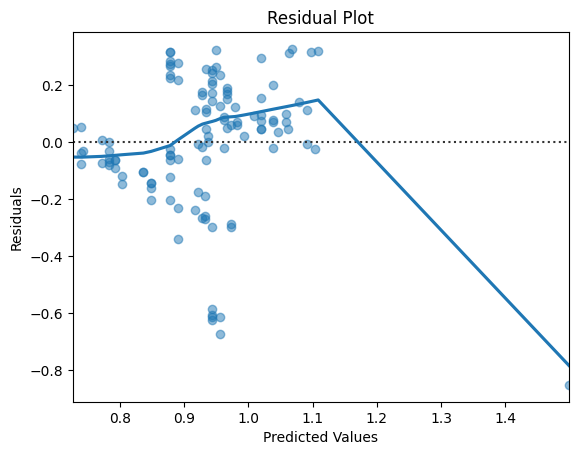

,Feature,Est. Coefficient,Standard Error,t-stat,p-val,95% CI
0,Intercept,0.897926,0.168238,5.337232,5.404210e-07,"(5.614e-01, 1.234e+00)"
1,Litter_size,-0.065089,0.013987,-4.653423,9.483446e-06,"(-9.306e-02, -3.711e-02)"
2,isFemale,0.011846,0.044505,0.266182,7.906164e-01,"(-7.716e-02, 1.009e-01)"
3,mat_is_HET,0.325273,0.128692,2.527537,1.296203e-02,"(6.789e-02, 5.827e-01)"
4,mat_is_fl/+,0.242019,0.129319,1.871487,6.403477e-02,"(-1.662e-02, 5.007e-01)"
5,mat_is_fl/fl,0.330634,0.132271,2.499681,1.396360e-02,"(6.609e-02, 5.952e-01)"
6,fet_is_het,0.279232,0.131737,2.119610,3.637349e-02,"(1.576e-02, 5.427e-01)"
7,fet_is_ko,0.294692,0.134137,2.196948,3.020138e-02,"(2.642e-02, 5.630e-01)"
8,fet_is_wt,0.324002,0.129982,2.492675,1.422615e-02,"(6.404e-02, 5.840e-01)"


In [434]:
alpha = 1
lm = Ridge(fit_intercept=False, alpha=alpha)
lm.fit(X, y_fm)
y_pred = lm.predict(X)
model_info(X, y_fm, y_pred, lm)

This model does a very poor job of predicting. I am not a fan of backwards selection, so I'll attempt to use bayesian model selection to decide which of these coefficients are even truly relevant (if any).

Note: we assume prior probability that $p(z_j = 1) = 0.5$

In [513]:
import scipy.special
from sklearn.linear_model import LinearRegression

def lpy_given_X(X, y):
    # Prior info
    n,p = X.shape
    g = y.shape[0]
    nu0 = 1

    lm = LinearRegression(fit_intercept=False)
    lm.fit(X, y)
    ypred = lm.predict(X)
    s20 = ((y - ypred).T @ (y - ypred)) / (n-p)

    Hg = (g/(g+1)) * X.values @ np.linalg.inv((X.T @ X)) @ X.T  # Note: df @ array did not work. Needed to convert the df to an array with .values to fix this code.
    SSRg = (y.T @ ((np.eye(n) - Hg) @ y)).values

    SSRg = 0
    
    beta_g = lm.coef_ * (g/(g+1))
    for i in range(g):
        SSRg += (y.values[i] - X.values[i] @ beta_g.T) ** 2
 
    print("The SSRg Value: " + str(SSRg))
    #print("The SSRg Value: " + str(SSRg2))


    lpy_given_X = -0.5 * (n*np.log(np.pi) + p*np.log(1 + g) + (nu0+n)*np.log(nu0*s20 + SSRg) - nu0*np.log(nu0*s20))
    lpy_given_X += scipy.special.gammaln((nu0+n)/2) - scipy.special.gammaln(nu0/2)

    return lpy_given_X

In [509]:
import random

def var_selection_mcmc(X, y, nsim=1000):
    n = X.shape[1]
    indices = [i for i in range(1, n)]

    # Z is where all the z vectors are stored
    Z = []
    z = np.ones(n)  # initialize z to a full model (all coefs active)
    lpy_current = lpy_given_X(X, y)

    for sim in range(nsim):
        # Update z
        random.shuffle(indices)  # Shuffle indices

        for j in indices:
            temp_z = z.copy()
            temp_z[j] = 1 - z[j]

            # Remove columns from DataFrame based on the indices
            to_drop = np.where(temp_z == 0)[0]
            modified_X = X.drop(X.columns[to_drop], axis=1)

            print("Model: " + str(temp_z))

            lpy_X = lpy_given_X(modified_X, y)
            r = (lpy_X - lpy_current)   # These are log odds, hence the minus
            r = r * -1 if z[j] == 0 else r  #The * -1 flips the fraction to ensure that it's always Odds(1)/Odds(0) for consistent probabilities

            z[j] = np.random.binomial(1, 1/(1+np.exp(-r))) # Probabilistically update z
            
            if (z[j] == temp_z[j]):
                lpy_current = lpy_X  # If it was accepted, update the current z value
            
        Z.append(z.copy()) # Store the probabilistically "winning" z

    # Turn Z into a df for easier computing
    Z = pd.DataFrame(np.mean(Z, axis=0)).T
    Z.columns = X.columns
    return Z

#var_selection_mcmc(X, y_fm, 100)

In [523]:
obs = 100

x1 = np.random.normal(34, 11, size=obs)
x2 = np.random.normal(164, 64, size=obs)
intercept = np.ones(obs)
y = 10*intercept + 1*x1 + 2*x2

testing_data = pd.DataFrame({'y':y, 'int':intercept, 'x1':x1, 'x2':x2})
y = testing_data[["y"]]
X = testing_data[["int", "x1", "x2"]]

lm = LinearRegression(fit_intercept=False)
lm.fit(X, y)
print(lm.coef_)

print(np.linalg.cond(X))

var_selection_mcmc(X, y, 10)

[[10.  1.  2.]]
837.8187327125638
The SSRg Value: [1629.76561938]
Model: [1. 1. 0.]
The SSRg Value: [1644302.22340097]
Model: [1. 0. 0.]
The SSRg Value: [1671803.2701986]
Model: [1. 0. 0.]
The SSRg Value: [1671803.2701986]
Model: [1. 1. 1.]
The SSRg Value: [1629.76561938]
Model: [1. 0. 0.]
The SSRg Value: [1671803.2701986]
Model: [1. 1. 1.]
The SSRg Value: [1629.76561938]
Model: [1. 1. 1.]
The SSRg Value: [1629.76561938]
Model: [1. 0. 0.]
The SSRg Value: [1671803.2701986]
Model: [1. 0. 1.]
The SSRg Value: [10876.83998447]
Model: [1. 1. 0.]
The SSRg Value: [1644302.22340097]
Model: [1. 1. 1.]
The SSRg Value: [1629.76561938]
Model: [1. 0. 0.]
The SSRg Value: [1671803.2701986]
Model: [1. 0. 1.]
The SSRg Value: [10876.83998447]
Model: [1. 1. 0.]
The SSRg Value: [1644302.22340097]
Model: [1. 0. 1.]
The SSRg Value: [10876.83998447]
Model: [1. 1. 0.]
The SSRg Value: [1644302.22340097]
Model: [1. 0. 0.]
The SSRg Value: [1671803.2701986]
Model: [1. 1. 1.]
The SSRg Value: [1629.76561938]
Model: 

,int,x1,x2
0,1.0,0.7,0.0


## Current Concerns:
1) Why does using SSRg from the book give a different value to my manually computed SSRg?
2) Why even use a g-prior? 
3) Review other implementations. There is clearly a misunderstanding somewhere within lpy.X
4) Plot distribution of mother weights. I bet this explains the fetal weight distribution or something

In [99]:
import statsmodels.formula.api as smf

# Fit the mixed effects model
model = smf.mixedlm("Fetal_mass ~ Litter_size + Maternal_genotype + isFemale + Maternal_genotype*Litter_size", groups=fetus["Dam"], data=fetus, re_formula="~ isFemale")
result = model.fit(method='bfgs', maxiter=1000)

# Print the summary of the model
print(result.summary())

                      Mixed Linear Model Regression Results
Model:                     MixedLM         Dependent Variable:         Fetal_mass
No. Observations:          115             Method:                     REML      
No. Groups:                15              Scale:                      0.0047    
Min. group size:           1               Log-Likelihood:             99.9378   
Max. group size:           12              Converged:                  No        
Mean group size:           7.7                                                   
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               2.294    1.550  1.480 0.139 -0.745  5.333
Maternal_genotype[T.fl/+]              -1.687    2.405 -0.701 0.483 -6.401  3.027
Maternal_genotype[T.fl/fl]            

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 0.556046
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, Convergence

In [54]:
# Fit the mixed effects model
model = smf.mixedlm("Placenta_mass ~ Litter_size + Maternal_genotype + isFemale", groups=fetus["Dam"], data=fetus, re_formula="~ isFemale")
result = model.fit(method='bfgs', maxiter=1000)

# Print the summary of the model
print(result.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


                Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    Placenta_mass
No. Observations:     115        Method:                REML         
No. Groups:           15         Scale:                 0.0002       
Min. group size:      1          Log-Likelihood:        270.6876     
Max. group size:      12         Converged:             Yes          
Mean group size:      7.7                                            
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   0.135    0.038  3.587 0.000  0.061  0.208
Maternal_genotype[T.fl/+]   0.013    0.022  0.577 0.564 -0.031  0.057
Maternal_genotype[T.fl/fl]  0.026    0.022  1.173 0.241 -0.017  0.069
Litter_size                -0.006    0.004 -1.363 0.173 -0.014  0.002
isFemale                   -0.002   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [58]:
# Fit the mixed effects model
model = smf.mixedlm("Fetal_placental_ratio ~ Litter_size + Maternal_genotype + isFemale", groups=fetus["Dam"], data=fetus, re_formula="~ isFemale")
result = model.fit(method='bfgs', maxiter=1000)

# Print the summary of the model
print(result.summary())

                Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: Fetal_placental_ratio
No. Observations:   115     Method:             REML                 
No. Groups:         15      Scale:              2.9233               
Min. group size:    1       Log-Likelihood:     -244.7764            
Max. group size:    12      Converged:          Yes                  
Mean group size:    7.7                                              
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                  11.711    4.150  2.822 0.005  3.578 19.845
Maternal_genotype[T.fl/+]  -2.509    2.475 -1.014 0.311 -7.360  2.343
Maternal_genotype[T.fl/fl] -3.134    2.350 -1.334 0.182 -7.741  1.472
Litter_size                 0.055    0.463  0.118 0.906 -0.852  0.961
isFemale                    0.386   

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
